In [1]:
from qiskit import Aer, execute, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

from time import time

In [24]:
# set number of assets (= number of qubits)
num_assets = 10
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2018, 1, 1),
    end=datetime.datetime(2018, 3, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [25]:
sigma

array([[ 7.59392137e-04, -3.68327607e-05, -1.51220518e-05,
         3.47598567e-05,  9.80746179e-06,  6.20182332e-06,
         1.89361671e-05, -2.36908856e-05, -2.91801053e-05,
         1.24871130e-05],
       [-3.68327607e-05,  1.11710377e-04,  1.63237428e-05,
         3.83861471e-05,  4.56143605e-07, -3.72607198e-05,
        -1.86771710e-05, -7.20883375e-06, -2.11190328e-05,
         8.72314848e-06],
       [-1.51220518e-05,  1.63237428e-05,  1.89906342e-04,
         8.15446963e-05,  1.58930258e-05, -6.03289112e-05,
        -1.39523128e-05, -1.50279723e-05, -1.63272706e-05,
        -5.65214848e-06],
       [ 3.47598567e-05,  3.83861471e-05,  8.15446963e-05,
         3.08927492e-03,  1.27053333e-04, -3.84050246e-04,
         3.53672436e-05, -4.69185138e-05, -6.81216919e-06,
         2.37712204e-05],
       [ 9.80746179e-06,  4.56143605e-07,  1.58930258e-05,
         1.27053333e-04,  6.40386254e-04, -2.87723091e-05,
        -1.21489983e-05,  2.43404194e-05, -3.38874278e-05,
         7.

In [26]:
mu

array([ 2.88520500e-03,  1.54469546e-03,  1.02519190e-04,  1.56356397e-03,
       -2.57041246e-03, -6.31579377e-03,  2.02568913e-03, -8.68847796e-04,
        3.44906844e-05,  1.48431311e-03])

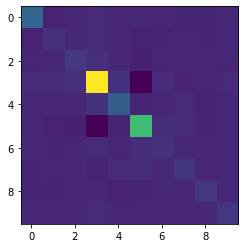

In [27]:
plt.imshow(sigma, interpolation="nearest")
plt.show()

#### Quadratic problem

In [28]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00037969606837460275*x_0^2 - 3.6832760681902446e..., 10 variables, 1 constraints, 'Portfolio optimization'>

In [29]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

#     eigenstate = result.min_eigen_solver_result.eigenstate
#     eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
#     probabilities = np.abs(eigenvector) ** 2
#     i_sorted = reversed(np.argsort(probabilities))
#     print("\n----------------- Full result ---------------------")
#     print("selection\tvalue\t\tprobability")
#     print("---------------------------------------------------")
#     for i in i_sorted:
#         x = index_to_selection(i, num_assets)
#         value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
#         # value = portfolio.to_quadratic_program().objective.evaluate(x)
#         probability = probabilities[i]
#         print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

#### VQE

In [30]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 1. 1. 0. 0. 0. 1. 0. 1. 0.], value -0.0060


#### QAOA

In [31]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 1. 1. 0. 0. 0. 1. 0. 0. 1.], value -0.0074


#### Decomposition

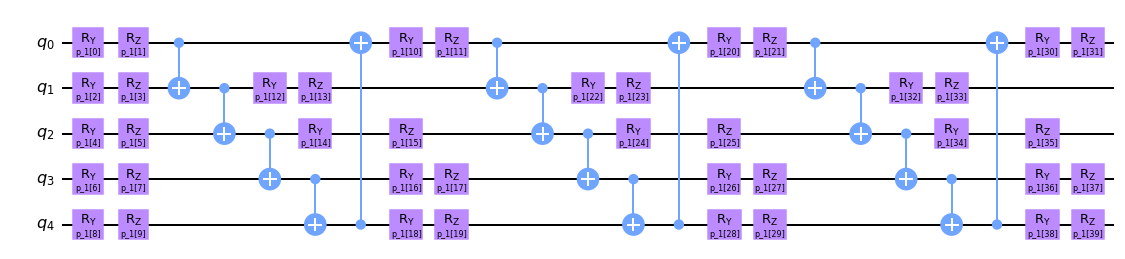

In [32]:
repeat = 4

qc = QuantumCircuit(5)
pv = ParameterVector('p_1', 10*repeat)

t = 0
for i in range(repeat):   
    qc.ry(pv[t], 0)
    qc.rz(pv[t+1],0)
    qc.ry(pv[t+2], 1)
    qc.rz(pv[t+3], 1)
    qc.ry(pv[t+4], 2)
    qc.rz(pv[t+5], 2)
    qc.ry(pv[t+6], 3)
    qc.rz(pv[t+7], 3)
    qc.ry(pv[t+8], 4)
    qc.rz(pv[t+9], 4)
    if i < repeat-1: 
        qc.cnot(0,1)
        qc.cnot(1,2)
        qc.cnot(2,3)
        qc.cnot(3,4)
        qc.cnot(4,0)
    t += 10

qc.draw(output="mpl")

In [33]:
qc = QuantumCircuit(10)
 
r = 4
theta = ParameterVector('p',2*10*r)

t = 0
for i in range(r):   
    qc.ry(theta[t], 0)
    qc.rz(theta[t+1],0)
    qc.ry(theta[t+2], 1)
    qc.rz(theta[t+3], 1)
    qc.ry(theta[t+4], 2)
    qc.rz(theta[t+5], 2)
    qc.ry(theta[t+6], 3)
    qc.rz(theta[t+7], 3)
    qc.ry(theta[t+8], 4)
    qc.rz(theta[t+9], 4)
    if i < r-1: 
        qc.cnot(0,1)
        qc.cnot(1,2)
        qc.cnot(2,3)
        qc.cnot(3,4)
        qc.cnot(4,0)
    t += 10

t = int(len(theta)/2)
for i in range(r):   
    qc.ry(theta[t], 5)
    qc.rz(theta[t+1],5)
    qc.ry(theta[t+2], 6)
    qc.rz(theta[t+3], 6)
    qc.ry(theta[t+4], 7)
    qc.rz(theta[t+5], 7)
    qc.ry(theta[t+6], 8)
    qc.rz(theta[t+7], 8)
    qc.ry(theta[t+8], 9)
    qc.rz(theta[t+9], 9)
    if i < r-1: 
        qc.cnot(5,6)
        qc.cnot(6,7)
        qc.cnot(7,8)
        qc.cnot(8,9)
        qc.cnot(9,0)
    t += 10

In [34]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

# backend = Aer.get_backend('aer_simulator')
# backend.shots = 1024

cobyla = COBYLA()
cobyla.set_options(maxiter=500)

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(qc, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print(result.x)

[1. 1. 1. 0. 0. 0. 1. 0. 0. 1.]
